<b style="font-size: 40px;">1. Pobierz i wczytaj dane</b>

In [1]:
#!wget https://dysk.agh.edu.pl/s/G6ZNziBRbEEcMeN/download/Bike-Sharing-Dataset.zip -O Bike-Sharing-Dataset.zip
#!unzip Bike-Sharing-Dataset.zip
#!cat Readme.txt

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.appName("BikerRental").master("local[*]").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/10 16:30:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv('day.csv', header=True, inferSchema=True)

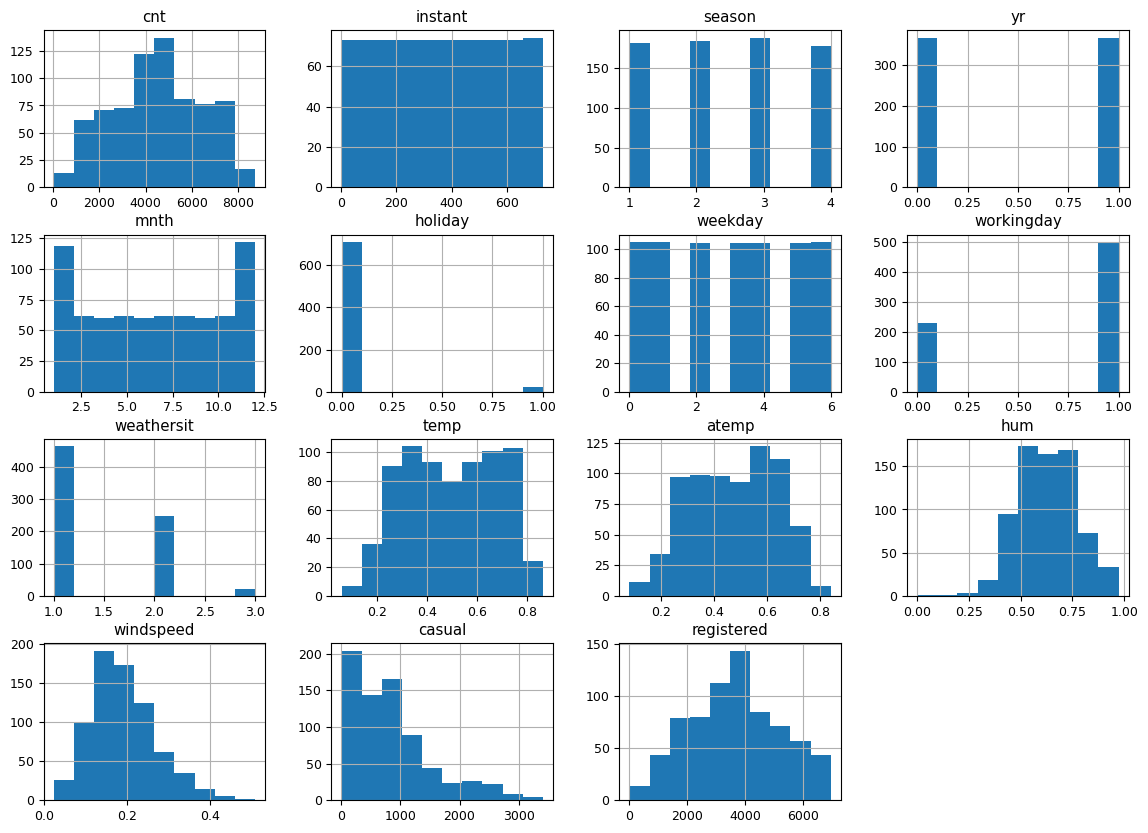

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,10)
plt.rcParams["font.size"] = 9
df = df.select('cnt', *[col for col in df.columns if col != 'cnt']) 
pdf = df.toPandas()
pdf.hist() 
plt.show()

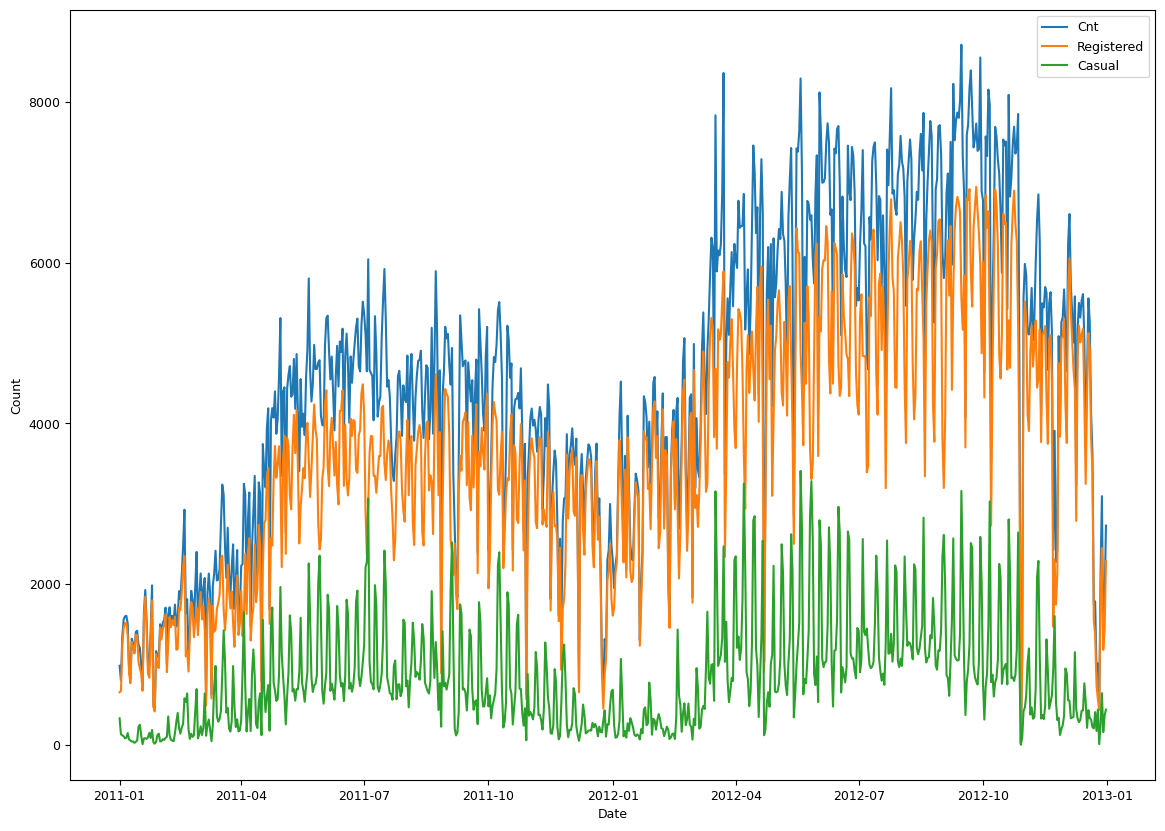

In [5]:
from pyspark.sql.functions import to_timestamp
import pandas as pd

dates = df.select('dteday').rdd.flatMap(lambda x:x).collect()
casual = df.select('casual').rdd.flatMap(lambda x:x).collect()
registered = df.select('registered').rdd.flatMap(lambda x:x).collect()
cnt = df.select('cnt').rdd.flatMap(lambda x:x).collect()

plt.plot(dates, cnt, label='Cnt') 
plt.plot(dates, registered, label='Registered') 
plt.plot(dates, casual, label='Casual') 
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

<b style="font-size: 40px;">2. Dane BASIC - regresja (bez przetwarzania wstępnego)</b>

In [6]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
 
def evaluate_metrics(df,metrics=['r2','rmse','mse','mae'],label_col='cnt',prediction_col='prediction'):
    results = {}
    evaluator = RegressionEvaluator() \
                .setLabelCol(label_col) \
                .setPredictionCol(prediction_col) \
    
    if 'r2' in metrics:
        evaluator.setMetricName("r2");
        results['r2'] = evaluator.evaluate(df)
    if 'rmse' in metrics:
        evaluator.setMetricName("rmse");
      
        results['rmse'] = evaluator.evaluate(df)
    if 'mse' in metrics:
        evaluator.setMetricName("mse");
        results['mse'] = evaluator.evaluate(df)
    if 'mae' in metrics:
        evaluator.setMetricName("mae");
        results['mae'] = evaluator.evaluate(df)
    
    return results

In [7]:
def train_and_test(df,lr=LinearRegression(maxIter=100,regParam=3.0,elasticNetParam=0.5), label_col="cnt"):

    lr = lr.setLabelCol(label_col)
    df_train, df_test = df.randomSplit([0.8, 0.2], seed=42)
    
    input_cols = [col for col in df.columns if col != label_col]
    assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
    
    pipeline = Pipeline(stages=[assembler, lr])
    
    model = pipeline.fit(df_train)
    
    train_predictions = model.transform(df_train)
    test_predictions = model.transform(df_test)
    
    train_metrics = evaluate_metrics(train_predictions)
    test_metrics = evaluate_metrics(test_predictions)
    
    print("Train Metrics:")
    print(train_metrics)
    print("Test Metrics:")
    print(test_metrics)
    
    return model

In [8]:
from pyspark.sql.functions import unix_timestamp
df2 = df.withColumn('unixdate',unix_timestamp('dteday')) 
df2 = df2.drop('dteday')

In [9]:
m = train_and_test(df2)

24/05/10 16:31:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/10 16:31:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Train Metrics:
{'r2': 0.9999974992652118, 'rmse': 3.030234333162533, 'mse': 9.182320113876983, 'mae': 2.433164540307507}
Test Metrics:
{'r2': 0.9999972712656053, 'rmse': 3.3566563248490087, 'mse': 11.267141683148854, 'mae': 2.7398900893612974}


In [10]:
last_stage = m.stages[-1]
print(last_stage.summary)

<i style="font-size: 30px;">Grid search</i>

In [11]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
 
cols = df2.columns
cols.remove('cnt')

va=VectorAssembler().setInputCols(cols).setOutputCol("features")

lr=LinearRegression()\
                      .setMaxIter(100)\
                      .setFeaturesCol("features")\
                      .setLabelCol("cnt")

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.5, 1, 2, 3, 5, 10]) \
    .addGrid(lr.elasticNetParam, [0.1, 0.25, 0.5, 0.75, 1.0]) \
    .build()

pipeline = Pipeline(stages=[va,lr])
 
 
evaluator = RegressionEvaluator(metricName='r2',labelCol='cnt',predictionCol='prediction')

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5,parallelism=4)

cvModel = crossval.fit(df2)
bestModel = cvModel.bestModel
print("Best model parameters:")
print("regParam:", bestModel.stages[-1].getRegParam())
print("elasticNetParam:", bestModel.stages[-1].getElasticNetParam())

24/05/10 16:31:42 WARN BlockManager: Block rdd_137_0 already exists on this machine; not re-adding it
24/05/10 16:31:42 WARN BlockManager: Block rdd_137_0 already exists on this machine; not re-adding it


Best model parameters:
regParam: 0.5
elasticNetParam: 1.0


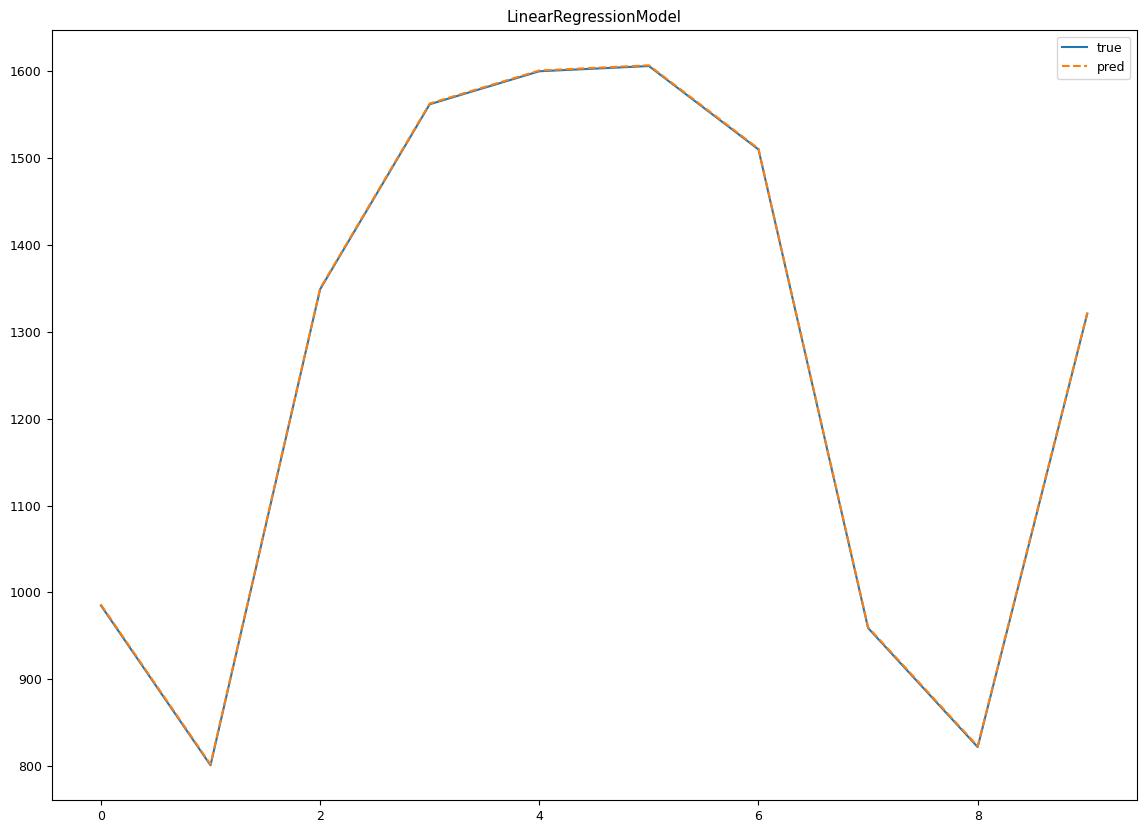

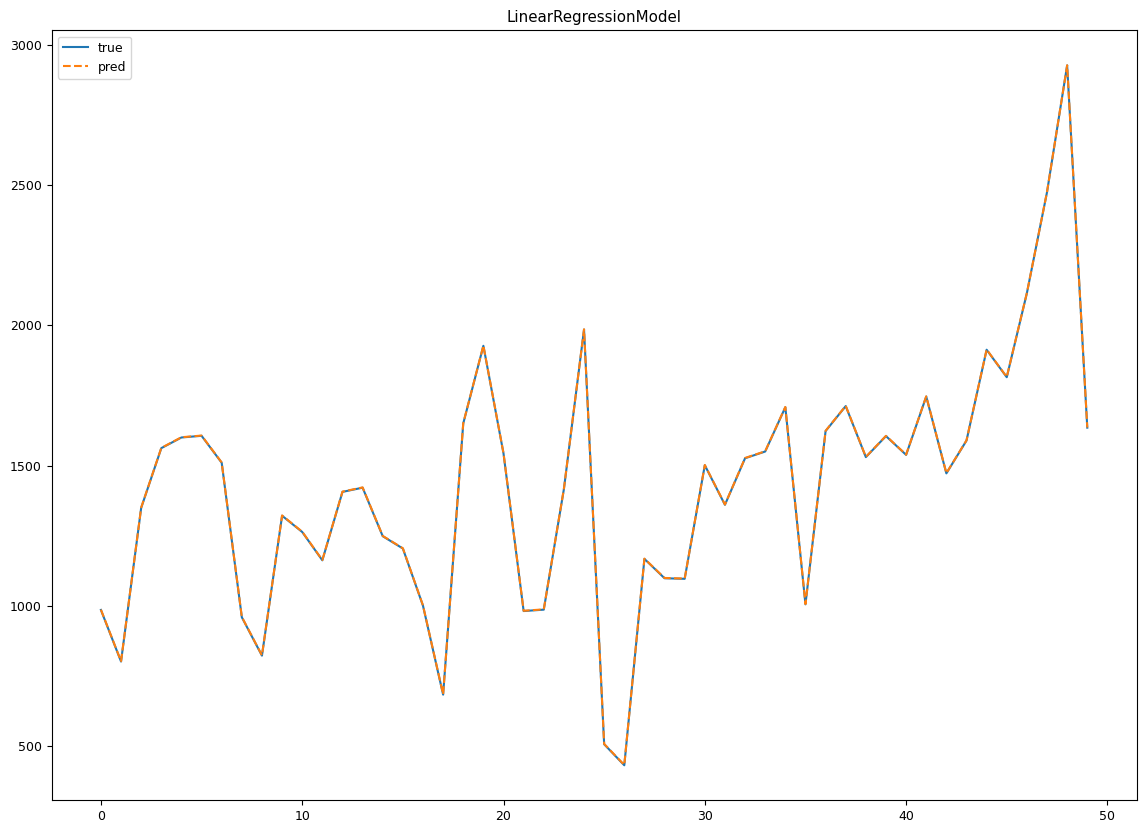

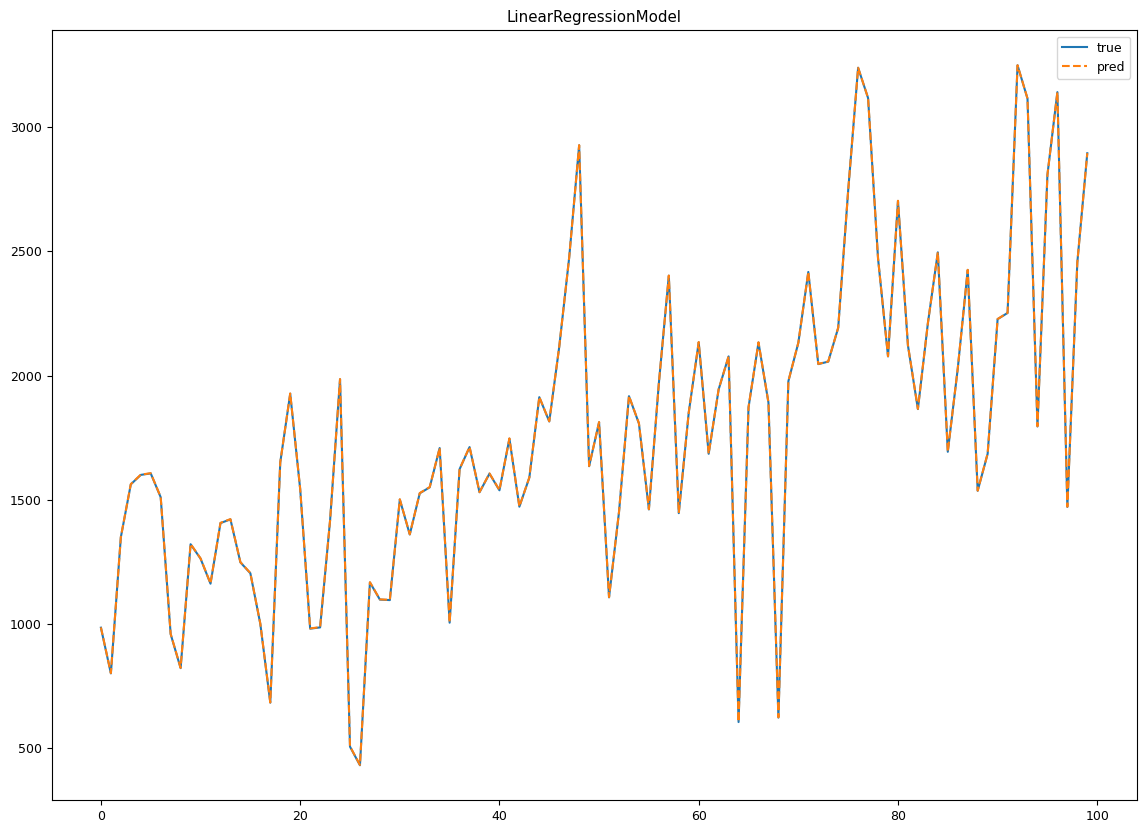

In [12]:
import numpy as np
 
def plot(df,model,start=0,end=-1, displayValues=True):
    if end == -1:
        end = df.count()
    x = np.arange(start, end)
    y = df.select('cnt').rdd.flatMap(lambda x: x).collect()
    df_pred = model.transform(df)
    y_pred = df_pred.select('prediction').rdd.flatMap(lambda x: x).collect()
    if displayValues == True:
        print("True values:", y[start:end])
        print("Predicted values:", y_pred[start:end])
    plt.plot(x, y[start:end], label='true', zorder=1)
    plt.plot(x, y_pred[start:end], label='pred', zorder=2, linestyle='dashed')
    plt.legend()
    plt.title(model.stages[-1].__class__.__name__)
    plt.show()

plot(df2,bestModel,start=0,end=10, displayValues=False)
plot(df2,bestModel,start=0,end=50, displayValues=False)
plot(df2,bestModel,start=0,end=100, displayValues=False)

<i style="font-size: 30px;">Przetestuj inne algorytmy</i>

In [13]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor

In [14]:
for r in [LinearRegression(maxIter=100,regParam=0.0,elasticNetParam=0.1),DecisionTreeRegressor(),RandomForestRegressor(),GBTRegressor()]:
    r.setLabelCol('cnt')
    r.setFeaturesCol('features')
    va = VectorAssembler(inputCols=[col for col in df2.columns if col != 'cnt'], outputCol='features')
    pipeline = Pipeline(stages=[va,r])
    model = pipeline.fit(df2)
    print(f'=== {r.__class__.__name__} ===')
    print("Train metrics: ",evaluate_metrics(model.transform(df2)))

24/05/10 16:32:49 WARN Instrumentation: [178e4175] regParam is zero, which might cause numerical instability and overfitting.
24/05/10 16:32:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/05/10 16:32:49 WARN Instrumentation: [178e4175] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


=== LinearRegression ===
Train metrics:  {'r2': 0.9999999626577178, 'rmse': 0.3740935303916851, 'mse': 0.1399459694809146, 'mae': 0.31876712685241704}
=== DecisionTreeRegressor ===


Train metrics:  {'r2': 0.9826083810989925, 'rmse': 255.2993883808855, 'mse': 65177.777707654204, 'mae': 198.60482465431326}
=== RandomForestRegressor ===
Train metrics:  {'r2': 0.9716830969539554, 'rmse': 325.76366784581285, 'mse': 106121.96728835709, 'mae': 242.68506149170906}
=== GBTRegressor ===
Train metrics:  {'r2': 0.9957791545336028, 'rmse': 125.7707049831092, 'mse': 15818.270231948289, 'mae': 97.60318853703923}


Linear jest najlepsza, wykres powyzej :)

<b style="font-size: 40px;">3. Dane PREPROCESS</b>

<i style="font-size: 30px;">3.1 Czy atrybuty są skorelowane z kolumną cnt</i>

In [15]:
import itertools

In [16]:
def correlation_table(df):
    n = len(df.columns) 
    rs = np.eye(n)
    
    for i in range(n):
        for j in range(n): 
            if df.columns[i] != 'cnt' or df.columns[j] != 'cnt':
                r = df.stat.corr(df.columns[i],df.columns[j])
                rs[i,j] = r 
    return rs

In [17]:
def plot_matrix(cm, labels,
                    normalize=False,
                    title='',
                    cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(10,10))
    ax=fig.add_subplot(111)
    ax.matshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(labels)
    # ax.set_yticklabels(['']+labels)
    ax.set_yticklabels(labels)
 
    fmt = '.2f' #if normalize else 'd'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.show()

In [18]:
c = correlation_table(df2)

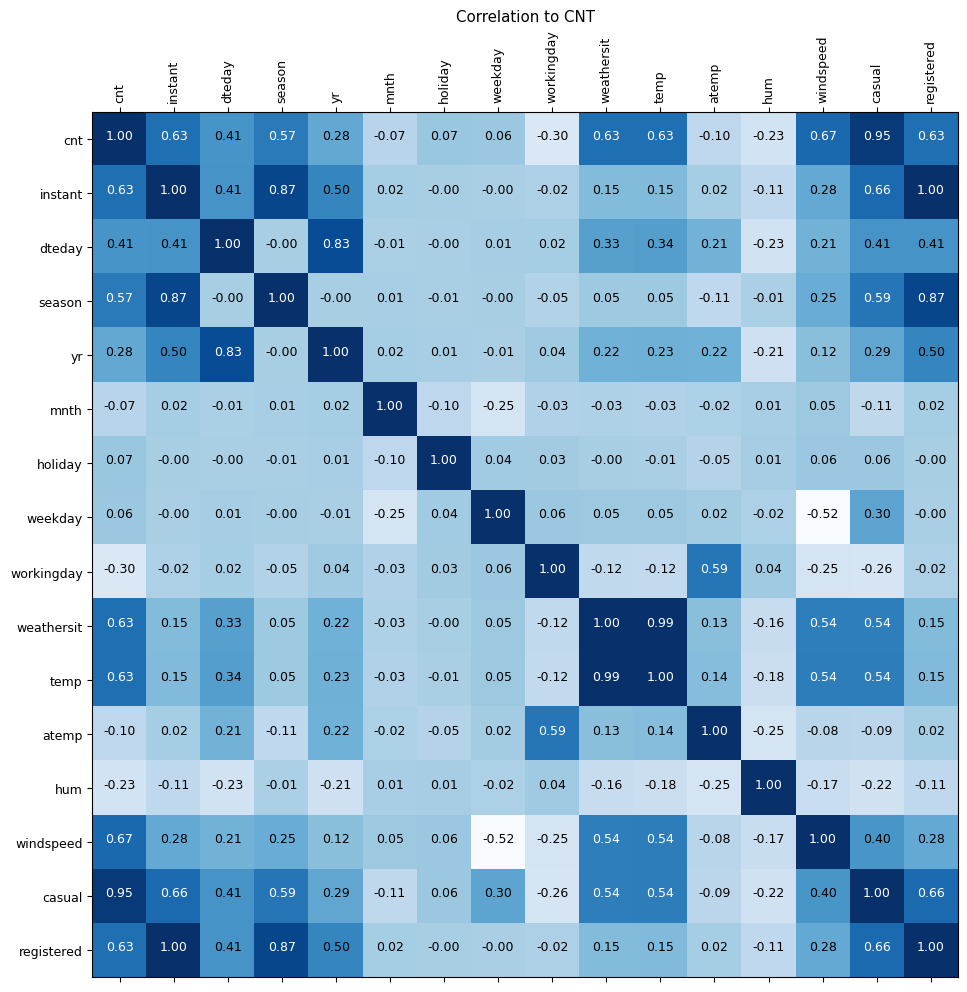

In [19]:
plot_matrix(c, df.columns, False, "Correlation to CNT")

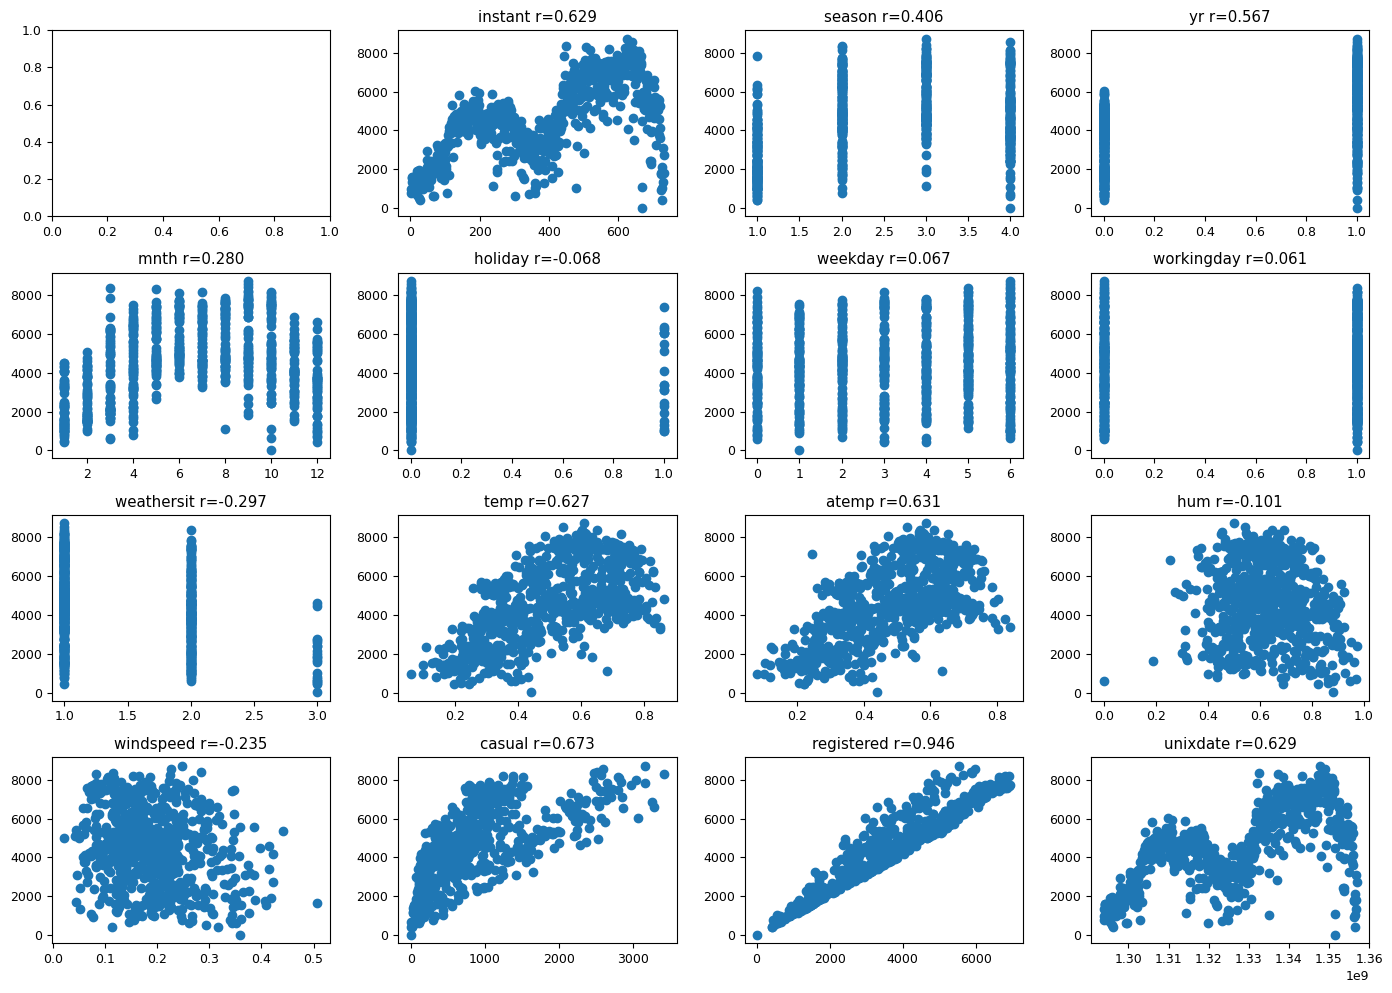

In [20]:
plt.rcParams["figure.figsize"] = (14,10)
plt.rcParams["font.size"] = 9
p, axes = plt.subplots(4, 4)
for i,col in enumerate(df2.columns):
    if col != 'cnt':
        r = df2.stat.corr(col,'cnt')
        x = df2.select(col).rdd.flatMap(lambda x:x).collect()
        y = df2.select('cnt').rdd.flatMap(lambda x:x).collect() 
        ax = axes[i//4,i%4]
        ax.scatter(x,y)
        ax.set_title(f'{col} r={r:.3f}')
plt.tight_layout()
plt.show()

<i style="font-size: 30px;">3.2 Konwersja one-hot i cechy wielomainowe</i>

In [21]:
from pyspark.ml.feature import OneHotEncoder
 
encoder = OneHotEncoder(inputCol="weekday", outputCol="categoryVec")
model = encoder.fit(df2)
df_encoded = model.transform(df2)
df_encoded.show()

+----+-------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----------+-------------+
| cnt|instant|season| yr|mnth|holiday|weekday|workingday|weathersit|    temp|   atemp|     hum|windspeed|casual|registered|  unixdate|  categoryVec|
+----+-------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----------+-------------+
| 985|      1|     1|  0|   1|      0|      6|         0|         2|0.344167|0.363625|0.805833| 0.160446|   331|       654|1293840000|    (6,[],[])|
| 801|      2|     1|  0|   1|      0|      0|         0|         2|0.363478|0.353739|0.696087| 0.248539|   131|       670|1293926400|(6,[0],[1.0])|
|1349|      3|     1|  0|   1|      0|      1|         1|         1|0.196364|0.189405|0.437273| 0.248309|   120|      1229|1294012800|(6,[1],[1.0])|
|1562|      4|     1|  0|   1|      0|      2|         1|         1|     0.2|0.212122|0.590435| 0.160296| 

In [22]:
from pyspark.ml.feature import OneHotEncoder
 
def encode_one_hot(df: DataFrame, cols: list[str]):
    df_encoded = df    
    for col in cols: 
        encoder = OneHotEncoder(inputCol=col, outputCol=f"{col}Vec")
        model = encoder.fit(df_encoded)
        df_encoded = model.transform(df_encoded)
        df_encoded = df_encoded.drop(col)
    return df_encoded

In [23]:
df3 = encode_one_hot(df2,["season","holiday","mnth", "yr", "weekday", "workingday", "weathersit"])
df3.show(2)

+---+-------+--------+--------+--------+---------+------+----------+----------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+
|cnt|instant|    temp|   atemp|     hum|windspeed|casual|registered|  unixdate|    seasonVec|   holidayVec|       mnthVec|        yrVec|   weekdayVec|workingdayVec|weathersitVec|
+---+-------+--------+--------+--------+---------+------+----------+----------+-------------+-------------+--------------+-------------+-------------+-------------+-------------+
|985|      1|0.344167|0.363625|0.805833| 0.160446|   331|       654|1293840000|(4,[1],[1.0])|(1,[0],[1.0])|(12,[1],[1.0])|(1,[0],[1.0])|    (6,[],[])|(1,[0],[1.0])|(3,[2],[1.0])|
|801|      2|0.363478|0.353739|0.696087| 0.248539|   131|       670|1293926400|(4,[1],[1.0])|(1,[0],[1.0])|(12,[1],[1.0])|(1,[0],[1.0])|(6,[0],[1.0])|(1,[0],[1.0])|(3,[2],[1.0])|
+---+-------+--------+--------+--------+---------+------+----------+----------+-------------+------------

<b style="font-size: 40px;">4. TIMESERIES - regresja szeregów czasowych</b>

<i style="font-size: 30px;">4.1 Dopasowanie krzywej trendu</i>

In [24]:
from pyspark.ml.feature import PolynomialExpansion
 
# Param for the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.
 
def train_polynomial_features(df,lr=LinearRegression(),degree=2):
    inputCols = [col for col in df.columns if col != "cnt"]
    va = VectorAssembler().setInputCols(inputCols).setOutputCol("features") 
    pe = PolynomialExpansion().setInputCol("features").setOutputCol("polyFeatures").setDegree(degree)
    pipeline = Pipeline(stages=[va, pe, lr])
    model = pipeline.fit(df)
    return model

24/05/10 16:33:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


True values: [985, 801, 1349, 1562, 1600, 1606, 1510, 959, 822, 1321, 1263, 1162, 1406, 1421, 1248, 1204, 1000, 683, 1650, 1927, 1543, 981, 986, 1416, 1985, 506, 431, 1167, 1098, 1096, 1501, 1360, 1526, 1550, 1708, 1005, 1623, 1712, 1530, 1605, 1538, 1746, 1472, 1589, 1913, 1815, 2115, 2475, 2927, 1635, 1812, 1107, 1450, 1917, 1807, 1461, 1969, 2402, 1446, 1851, 2134, 1685, 1944, 2077, 605, 1872, 2133, 1891, 623, 1977, 2132, 2417, 2046, 2056, 2192, 2744, 3239, 3117, 2471, 2077, 2703, 2121, 1865, 2210, 2496, 1693, 2028, 2425, 1536, 1685, 2227, 2252, 3249, 3115, 1795, 2808, 3141, 1471, 2455, 2895]
Predicted values: [894.847092252858, 836.2061189457388, 1464.772341725749, 1465.525007556728, 1694.4161435904275, 1471.3894259243552, 1578.925445885538, 988.3003645426036, 795.0534190899759, 1400.4287501933518, 1282.5872624033034, 1197.6777950590663, 1267.4014524487036, 1425.154079072241, 1293.6332913645435, 1192.1699547572425, 1014.1524657276108, 692.8073993745047, 1604.9437664635814, 1951.897

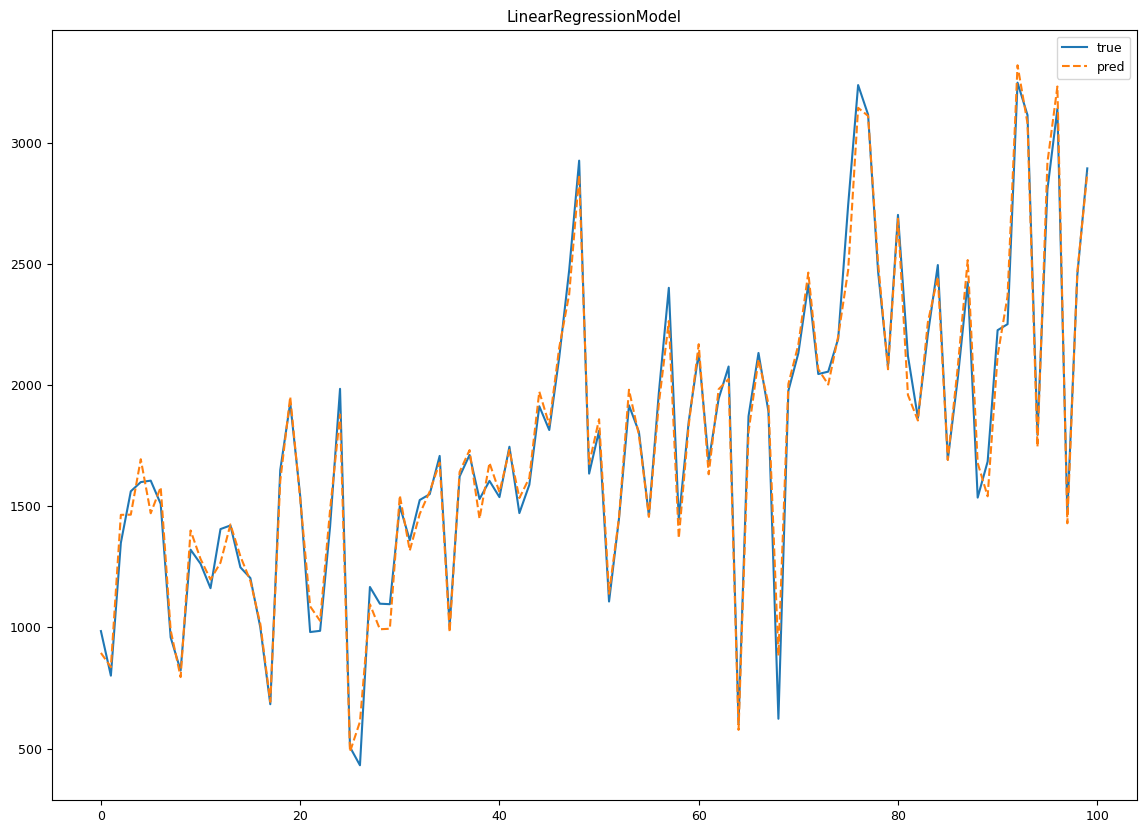

In [25]:
model = train_polynomial_features(df3,lr=LinearRegression(maxIter=20,regParam=0.02,elasticNetParam=1, 
                                                          featuresCol="polyFeatures", labelCol="cnt"),degree=3)
#print(model.stages[-1].coefficients)
#print('Iterations: ',model.stages[-1].summary.totalIterations)
plot(df3, model, 0, 100)

<i style="font-size: 30px;">4.2 Analiza cech okresowych</i>

<i style="font-size: 20px;">4.2.1 Autokorelacja</i>

In [26]:
!pip install seaborn
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 555.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 KB 860.7 kB/s eta 0:00:00a 0:00:01


<Axes: >

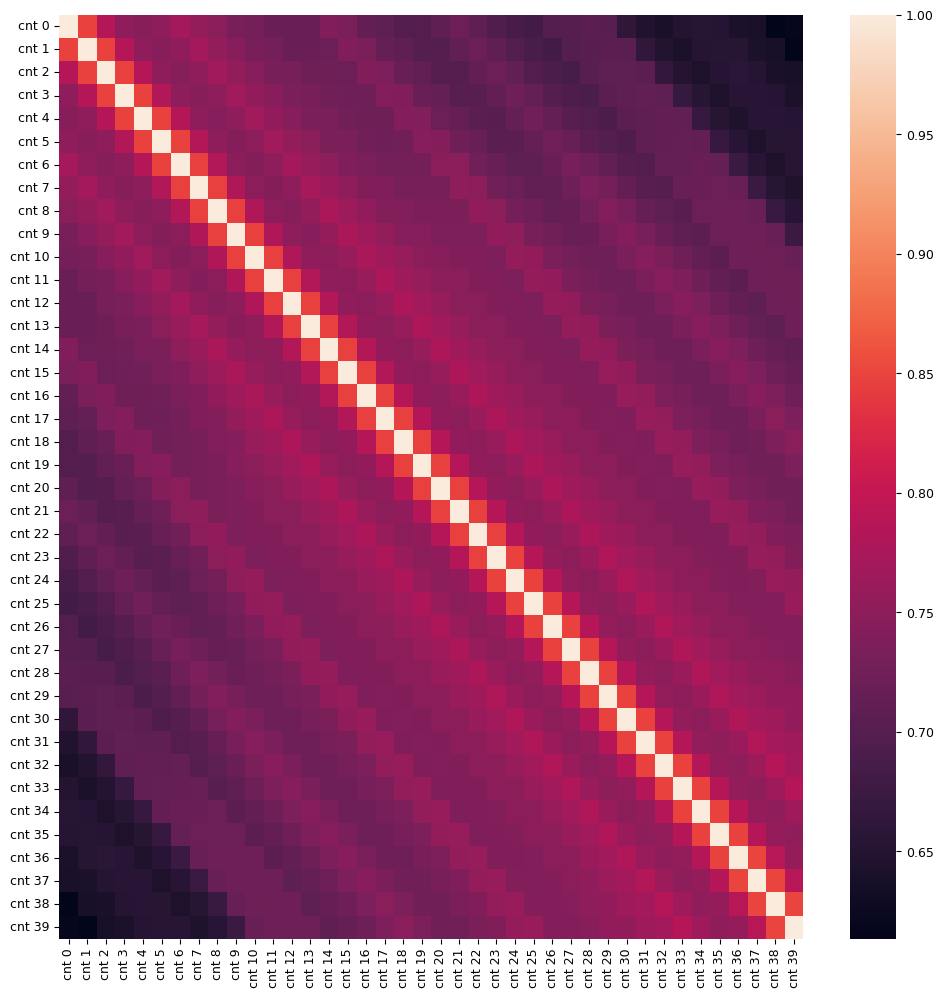

In [27]:
import pandas as pd
pdf = df.toPandas()
shifted = [pd.DataFrame(data = pdf.cnt).shift(i) for i in range(40)]
for i in range(len(shifted)):
  shifted[i].columns=['cnt '+str(i)]
# print(shifted)
df_shifted = pd.concat(shifted,axis=1)
# df_shifted.head(20)
 
corr_mat = df_shifted.corr()
import seaborn as sn
plt.rcParams['figure.figsize'] = (12, 12)
sn.heatmap(corr_mat,xticklabels=df_shifted.columns,yticklabels=df_shifted.columns)

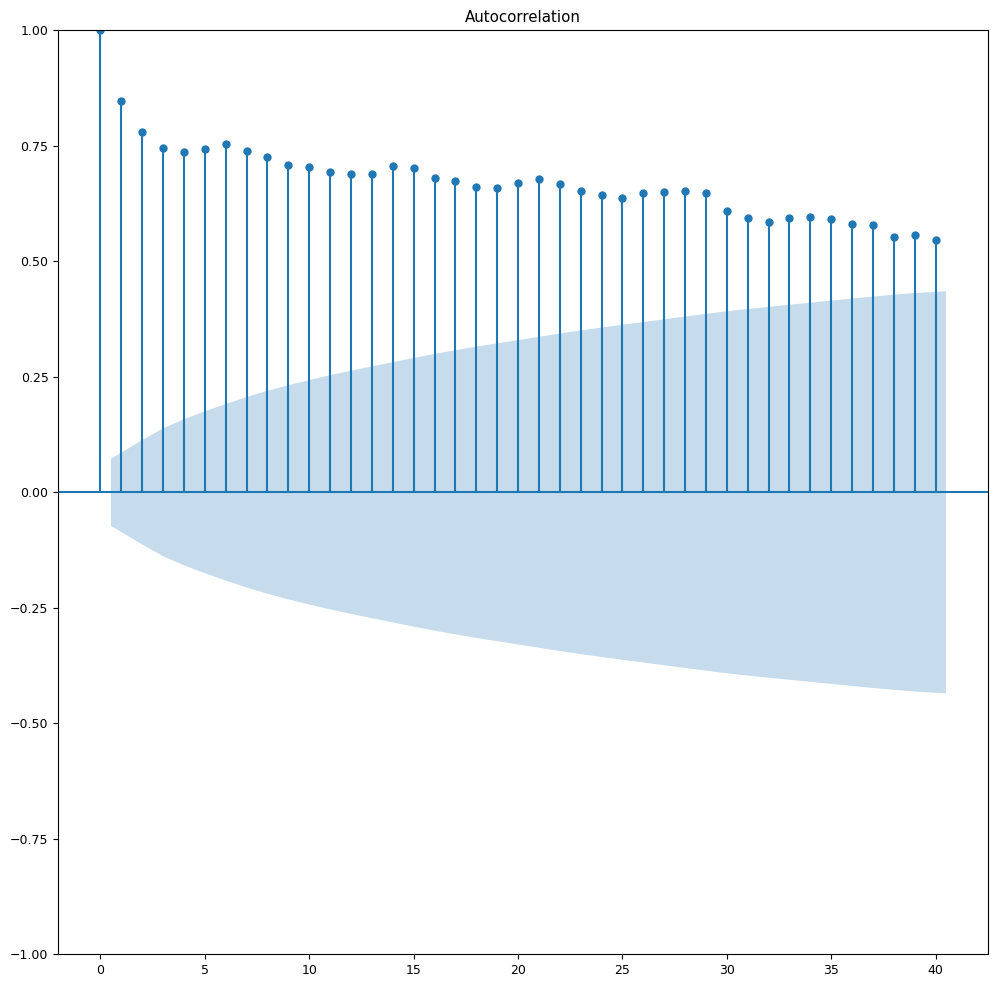

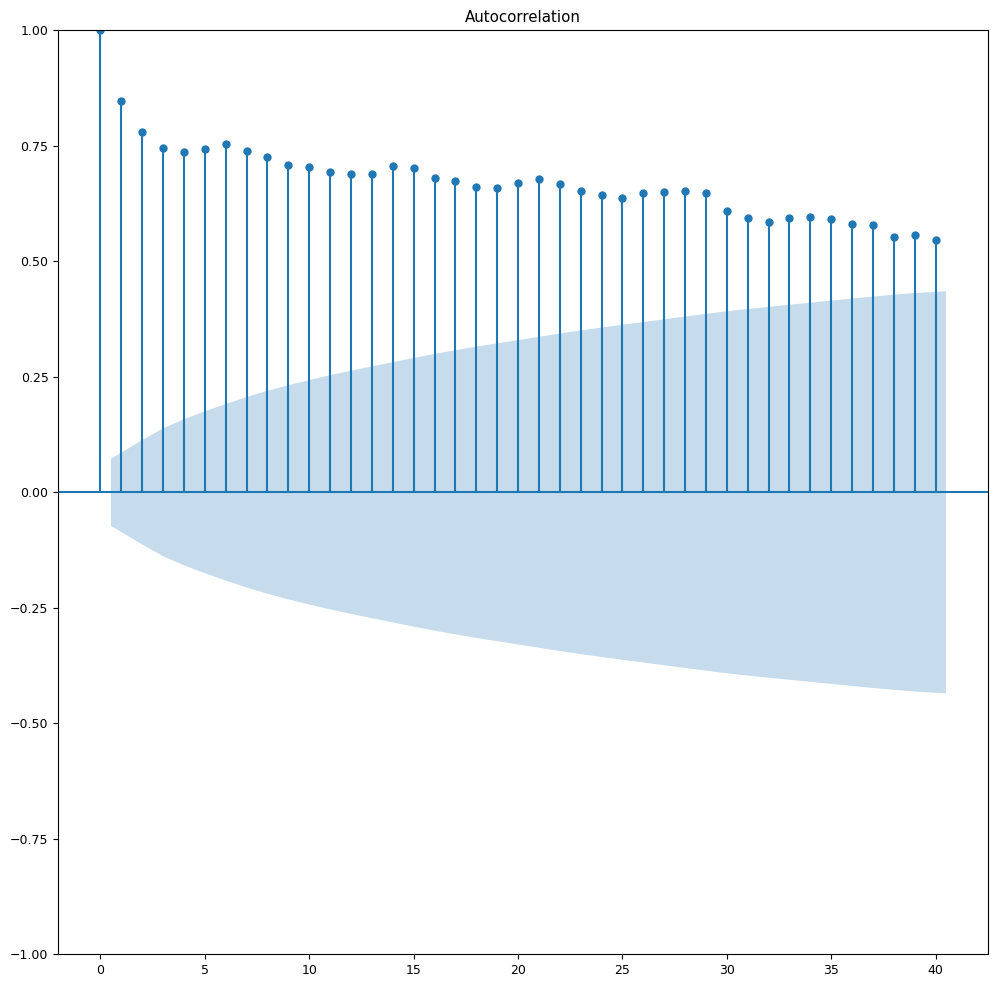

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(pdf.cnt,lags=40)

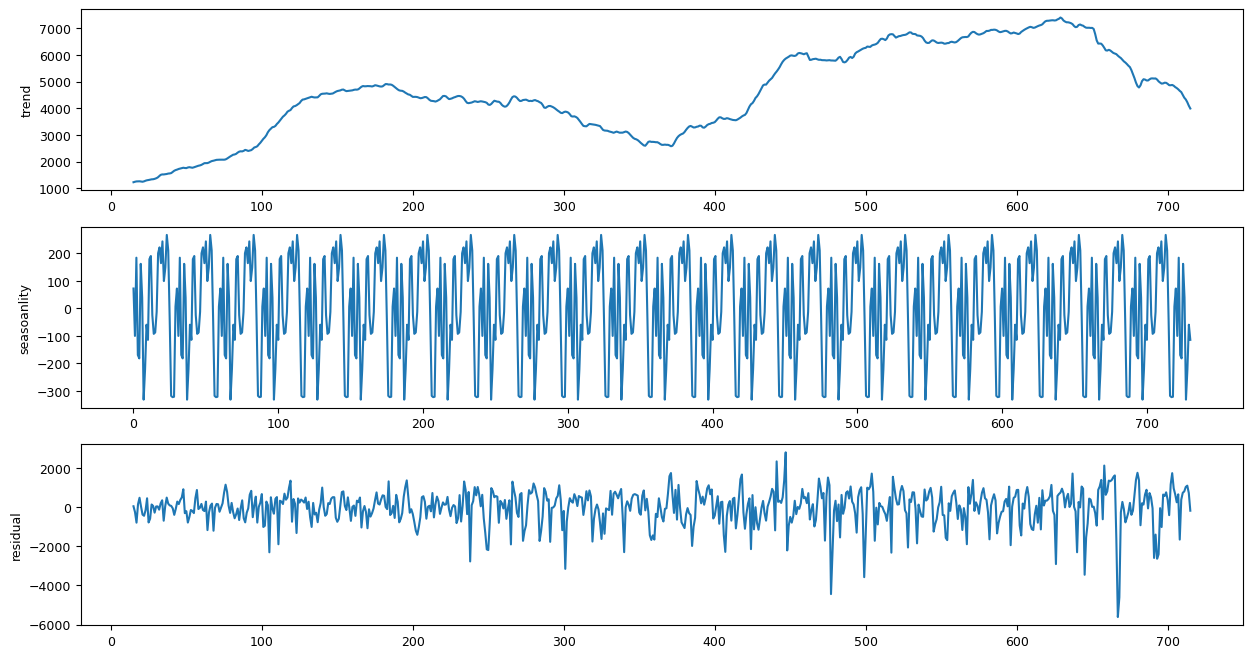

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
 
res = seasonal_decompose(pdf.cnt, model = "additive",period=30)
 
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.seasonal.plot(ax=ax2,ylabel = "seasoanlity")
res.resid.plot(ax=ax3,ylabel = "residual")
plt.show()

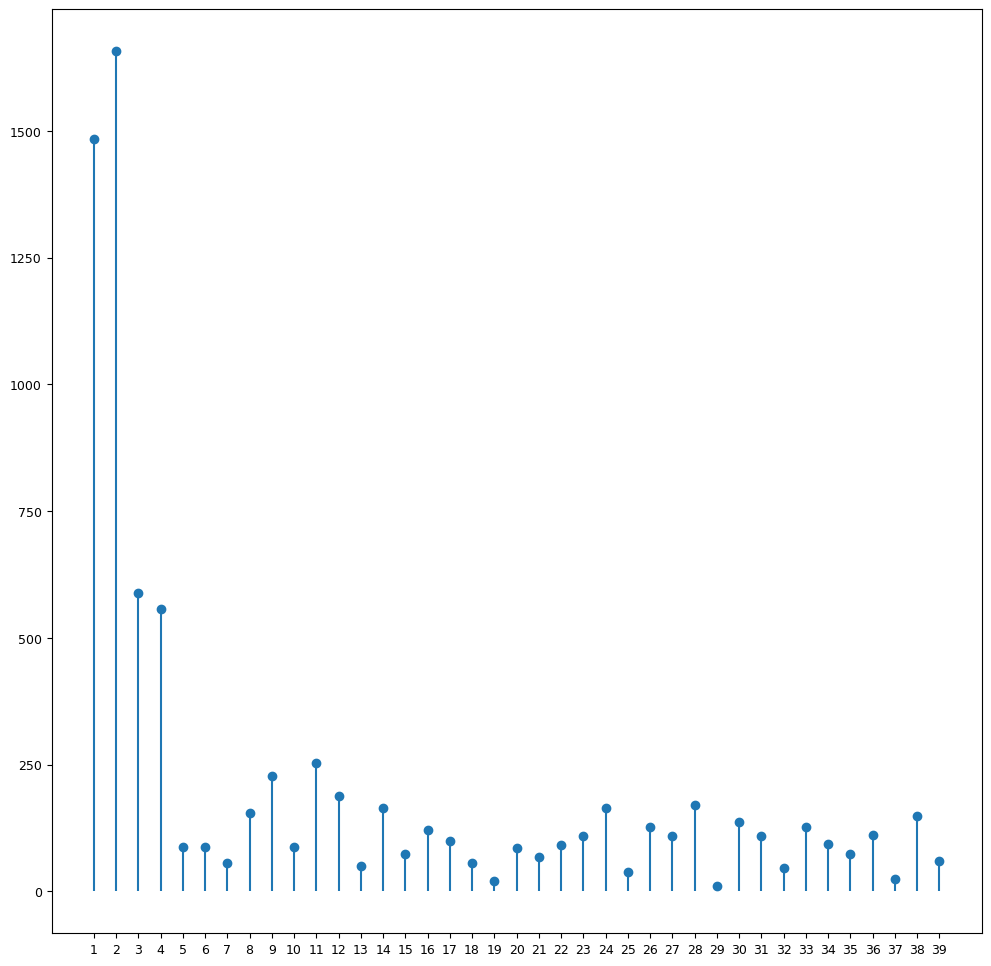

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
 
y = pdf.cnt.to_numpy()
x = np.arange(-y.shape[0]//2,y.shape[0]//2)
 
yf = scipy.fftpack.fft(y)
 
N=y.shape[0]
 
yf = scipy.fftpack.fft(y)
yf[0]=0
xf = np.arange(1,40)
 
plt.scatter(xf, 2.0/N * np.abs(yf[1:40]))
plt.vlines(xf, np.zeros(39),2.0/N * np.abs(yf[1:40]))
plt.xticks(xf)
plt.show()

<i style="font-size: 20px;">4.2.3 Cechy Okresowe</i>

In [35]:
periods = [8, 9, 11, 12, 14]
 
df4 = df2
cols=[]
for k in periods:
    df4 = df4.withColumn(f'sin_{k}',expr(f'sin(2*3.141592*{k}*unixdate)'))
    df4 = df4.withColumn(f'cos_{k}',expr(f'cos(2*3.141592*{k}*unixdate)'))
    cols.append(f'sin_{k}')
    cols.append(f'cos_{k}')

df4.show(5)

+----+-------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
| cnt|instant|season| yr|mnth|holiday|weekday|workingday|weathersit|    temp|   atemp|     hum|windspeed|casual|registered|  unixdate|              sin_8|               cos_8|               sin_9|               cos_9|             sin_11|             cos_11|             sin_12|              cos_12|              sin_14|              cos_14|
+----+-------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------

In [44]:
def train_polynomial_periodic_features(df,lr=LinearRegression(),degree=2,cols=[]):

    va1 = VectorAssembler(inputCols=["instant"], outputCol="features")
    pe = PolynomialExpansion(degree=degree, inputCol="features", outputCol="features_poly")
    va2 = VectorAssembler(inputCols=cols + ["features_poly"], outputCol="features_merged")

    #featuresCol="polyFeatures", labelCol="cnt"
    lr.setFeaturesCol("features_merged")
    lr.setLabelCol("cnt")
    
    pipeline = Pipeline(stages=[va1, pe, va2, lr])
    
    model = pipeline.fit(df)
    
    return model

[174.08271118549405,-77.07763851640657,5.741146300772492,-50.36740101630475,16.07452791838242,-63.5775078546608,-6.2122268946154335,-43.363491275217335,4.312671602335211,-23.055206180864865,9.051611235710643,0.0028792940960080484,-1.1157266862013077e-05]
Iterations:  50
True values: [985, 801, 1349, 1562, 1600, 1606, 1510, 959, 822, 1321, 1263, 1162, 1406, 1421, 1248, 1204, 1000, 683, 1650, 1927, 1543, 981, 986, 1416, 1985, 506, 431, 1167, 1098, 1096, 1501, 1360, 1526, 1550, 1708, 1005, 1623, 1712, 1530, 1605, 1538, 1746, 1472, 1589, 1913, 1815, 2115, 2475, 2927, 1635, 1812, 1107, 1450, 1917, 1807, 1461, 1969, 2402, 1446, 1851, 2134, 1685, 1944, 2077, 605, 1872, 2133, 1891, 623, 1977, 2132, 2417, 2046, 2056, 2192, 2744, 3239, 3117, 2471, 2077, 2703, 2121, 1865, 2210, 2496, 1693, 2028, 2425, 1536, 1685, 2227, 2252, 3249, 3115, 1795, 2808, 3141, 1471, 2455, 2895, 3348, 2034, 2162, 3267, 3126, 795, 3744, 3429, 3204, 3944, 4189, 1683, 4036, 4191, 4073, 4400, 3872, 4058, 4595, 5312, 3351, 4

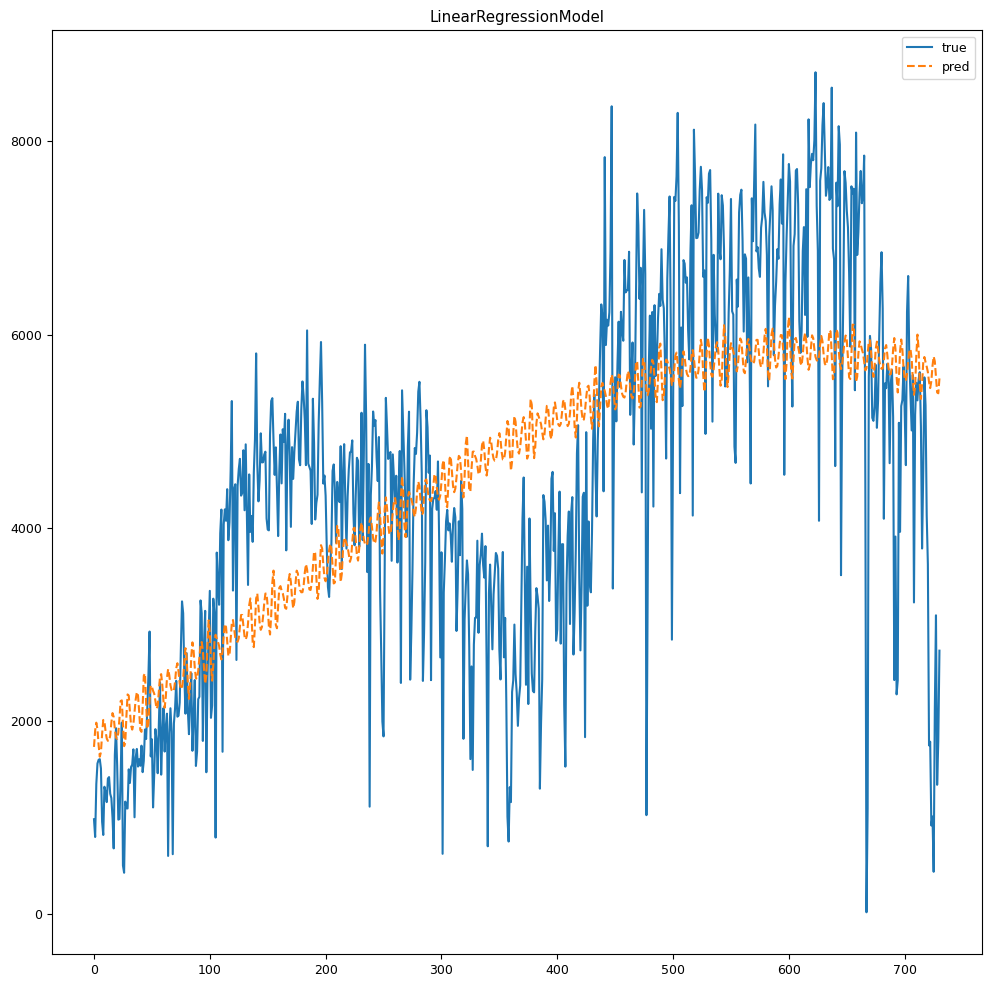

In [50]:
model = train_polynomial_periodic_features(df4,
                                           lr=LinearRegression(maxIter=50,regParam=0.01,elasticNetParam=0.8),
                                           degree=3,cols=cols)
print(model.stages[-1].coefficients)
print('Iterations: ',model.stages[-1].summary.totalIterations)
plot(df4,model)